In [1]:
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import evaluation_vectorization as ev
import random
import config

sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))
import FigureConfig as FC

# Random Seed

In [2]:
seed = 0

random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

# Device

In [3]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:0')
device = 'cpu'
device

'cpu'

# Dataset

In [4]:
if config.current_dataset is not None:
    ds = config.datasets[config.current_dataset]
else:
    ds = config.datasets[0]

ds

'VertebralColumn_c3'

In [5]:
datapath = os.path.join(config.path, f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']
E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([310, 6]), torch.Size([310]), 310, 6, 3)

## Pseudo-electrical Signal

In [6]:
# normalization
X = X - torch.min(X, axis=0)[0]
X = X / torch.max(X, axis=0)[0]
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
test_rate = 0.2
valid_rate = 0.2
E_train = min(8096, int(E*train_rate))
E_test = min(2048, int(E*test_rate))
E_valid = min(2048, int(E*valid_rate))

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_test])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_test-E_valid])

len(train_data), len(test_data), len(valid_data)

(186, 62, 62)

In [8]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

In [9]:
M_valid = 500
K_valid = 50

# Evaluation

## Load Models

In [10]:
with open(f'./result/{ds}_NN_{seed}.p', 'rb') as f:
    NN = pickle.load(f)
NN.to(device)

Sequential(
  (0): Linear(in_features=6, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): Tanh()
)

In [11]:
with open(f'./result/{ds}_PNN_{seed}.p', 'rb') as f:
    PNN = pickle.load(f)
PNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

In [12]:
with open(f'./result/{ds}_AAPNN_{seed}.p', 'rb') as f:
    AAPNN = pickle.load(f)
AAPNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

# Get Structure

In [13]:
structure_NN = ev.GetStructure(NN)
structure_PNN = ev.GetStructure(PNN)
structure_AAPNN = ev.GetStructure(AAPNN)
structure_NN, structure_PNN, structure_AAPNN

('_6_3_3', '_6_3_3', '_6_3_3')

In [14]:
if (structure_NN == structure_PNN) and (structure_NN == structure_AAPNN):
    structure = structure_NN
    print(structure)
else:
    print('*** The structures are not identical!!!')

_6_3_3


## Evaluation

In [15]:
for x_valid, y_valid in valid_loader:
    prediction_valid = NN(x_valid)
    p = torch.argmax(prediction_valid, 1)
    pred_y = p.cpu().data.numpy().squeeze()
    acc_valid = sum(pred_y == y_valid.cpu().numpy()) / y_valid.shape[0]

acc_valid

0.7741935483870968

In [16]:
mean_acc_PNN, std_acc_PNN, mean_maa_PNN, std_maa_PNN = ev.Evaluation(PNN, valid_loader, M_valid, 100, K_valid, device)

  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
mean_acc_AAPNN, std_acc_AAPNN, mean_maa_AAPNN, std_maa_AAPNN = ev.Evaluation(AAPNN, valid_loader, M_valid, 100, K_valid, device)

  0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
np.savetxt(f'./result/figures/{ds}_PNN_ACC_{seed}_{int(np.mean(mean_acc_PNN)*1000)}.txt', np.vstack((mean_acc_PNN, std_acc_PNN)))
np.savetxt(f'./result/figures/{ds}_AAPNN_ACC_{seed}_{int(np.mean(mean_acc_AAPNN)*1000)}.txt', np.vstack((mean_acc_AAPNN, std_acc_AAPNN)))

np.savetxt(f'./result/figures/{ds}_PNN_MAA_{seed}_{int(np.mean(mean_maa_PNN)*1000)}.txt', np.vstack((mean_maa_PNN, std_maa_PNN)))
np.savetxt(f'./result/figures/{ds}_AAPNN_MAA_{seed}_{int(np.mean(mean_maa_AAPNN)*1000)}.txt', np.vstack((mean_maa_AAPNN, std_maa_AAPNN)))

# Visualization

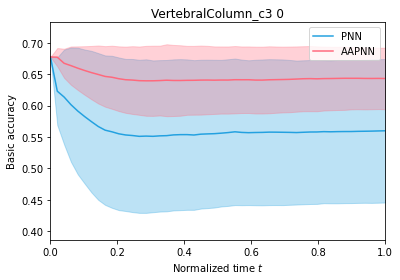

In [19]:
plt.fill_between(np.linspace(0,1,50), mean_acc_PNN-std_acc_PNN, mean_acc_PNN+std_acc_PNN, alpha=0.3, color=FC.Cyan);
plt.fill_between(np.linspace(0,1,50), mean_acc_AAPNN-std_acc_AAPNN, mean_acc_AAPNN+std_acc_AAPNN, alpha=0.3, color=FC.Pink);

plt.plot(np.linspace(0,1,50), mean_acc_PNN, label='PNN', color=FC.Cyan);
plt.plot(np.linspace(0,1,50), mean_acc_AAPNN, label='AAPNN', color=FC.Pink);

plt.title(f'{ds} {seed}')
plt.xlabel('Normalized time $t$');
plt.ylabel('Basic accuracy');
plt.xlim([0, 1]);
plt.ylim([max([0, 0.9*min([min(mean_acc_PNN-std_acc_PNN), min(mean_acc_AAPNN-std_acc_AAPNN)])]),
          min([1, 1.05*max([max(mean_acc_PNN+std_acc_PNN), max(mean_acc_AAPNN+std_acc_AAPNN)])])]);
plt.legend();
plt.savefig(f'./result/figures/{ds}_ACC_{seed}.pdf', format='pdf', bbox_inches='tight')

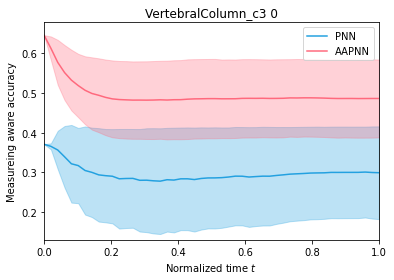

In [20]:
plt.fill_between(np.linspace(0,1,50), mean_maa_PNN-std_maa_PNN, mean_maa_PNN+std_maa_PNN, alpha=0.3, color=FC.Cyan);
plt.fill_between(np.linspace(0,1,50), mean_maa_AAPNN-std_maa_AAPNN, mean_maa_AAPNN+std_maa_AAPNN, alpha=0.3, color=FC.Pink);

plt.plot(np.linspace(0,1,50), mean_maa_PNN, label='PNN', color=FC.Cyan);
plt.plot(np.linspace(0,1,50), mean_maa_AAPNN, label='AAPNN', color=FC.Pink);

plt.title(f'{ds} {seed}')
plt.xlabel('Normalized time $t$');
plt.ylabel('Measureing aware accuracy');
plt.xlim([0, 1]);
plt.ylim([max([0, 0.9*min([min(mean_maa_PNN-std_maa_PNN), min(mean_maa_AAPNN-std_maa_AAPNN)])]),
          min([1, 1.05*max([max(mean_maa_PNN+std_maa_PNN), max(mean_maa_AAPNN+std_maa_AAPNN)])])]);
plt.legend();
plt.savefig(f'./result/figures/{ds}_MAA_{seed}.pdf', format='pdf', bbox_inches='tight')